In [73]:
%load_ext autoreload
%autoreload 2

%reload_ext autoreload

In [76]:
%alias nbconvert nbconvert Layout2.ipynb
%nbconvert

[NbConvertApp] Converting notebook Layout2.ipynb to python


In [1]:
import logging
from pathlib import Path
import copy
from PIL import Image, ImageDraw, ImageFont

In [2]:
try:
    from . import constants
except ImportError as e:
    import constants
    
try: 
    from . import Block as Block
except ImportError as e:
    import Block as Block

In [3]:
def strict_enforce(*types):
    """strictly enforce type compliance within classes
    
    Usage:
        @strict_enforce(type1, type2, (type3, type4))
        def foo(val1, val2, val3):
            ...
    """
    def decorator(f):
        def new_f(self, *args, **kwds):
            #we need to convert args into something mutable   
            newargs = []        
            for (a, t) in zip(args, types):
                if not isinstance(a, t):
                    raise TypeError(f'"{a}" is not type {t}')
#                 newargs.append( t(a)) #feel free to have more elaborated convertion
            return f(self, *args, **kwds)
        return new_f
    return decorator

In [61]:
class Layout:
    """Class for defining layout of epd screen
    
    This class allows screen layouts to be declared in terms of image blocks within an area. 
    Block placement is defined in terms of absolute or relative positions. Only one block 
    with absolute coordinates is needed. Block size is calculated based on screen size making
    it possible to define one layout that will work on screens of different dimensions.
    
    layouts are specified using the following key/value pairs. Those marked with a * are required
    for all blocks
    *'image': (None/True)          # None/False indicates this will NOT be an image block
    'max_lines': (int)             # maximum number of lines of text this block can accomodate
    'padding': (int)               # number of pixles to add around an image
    *'widht': (int/real)           # fractional portion of screen width this block occupies e.g. 
                                   # 1/2, 1, .25
    *'height': (int/real)          # fractional portion of the screen height this block occupies
    *'abs_coordinates': (tuple)    # tuple of X, Y coordinates where this block lies within the 
                                   # larger screen area. EVERY layout must have at least one block
                                   # that is defined ABSOLUTELY - typically: (0, 0)
                                   # When a block is placed relative to another
                                   # block use `None` to indicate that this is a calculated coordiante
                                   # e.g. (0, None) - Use an absolute value of X=0 and Y=None(calculated)
    'hcenter': (bool)              # horizontally center the text and image of the text in the block
    'vcenter': (bool)              # vertically center the text within the image block
    'rand' (bool)                  # True: randomply place the image within the area (overrides v/h center)
    *'relative': (False/list)      # False for blocks with absolute position; use a list other blocks
                                   # to use for calculating the position of this block e.g.
                                   # ['coverart', title] - reference the block `coverart` for the 
                                   # X position and `title` for the Y position of this block
    'font': (str):                 # Path to font file (relative paths are acceptable)
    'font_size': (None/int)        # None - calculate the font size, int - size in points
    'inverse': (bool)              # True: use black background, white fill

    
    Layouts are defined using any name and can be updated by calling the update() method with 
    a parameter that includes a dictionary containing a key/value pair that matches the names
    see the example below.
    Sample Laout:
    myLayout = {
        'title': {                       # text only block
            'image': None,               # do not expect an image
            'max_lines': 2,              # number of lines of text
            'width': 1,                  # 1/1 of the width - this stretches the entire width of the display
            'height': 2/3,               # 1/3 of the entire height
            'abs_coordinates': (0, 0),   # this block is the key block that all other blocks will be defined in terms of
            'hcenter': True,             # horizontally center text
            'vcenter': True,             # vertically center text 
            'relative': False,           # this block is not relative to any other. It has an ABSOLUTE position (0, 0)
            'font': './fonts/Anton/Anton-Regular.ttf', # path to font file
            'font_size': None            # Calculate the font size because none was provided
        }
    
        'artist' {
            'image': None,
            'max_lines': 1,
            'width': 1,
            'height', 1/3,
            'abs_coordinates': (0, None)   # X = 0, Y will be calculated
            'hcenter': True,
            'vcenter': True,
            'relative': ['artist', title], # use the X postion from abs_coord from `artist` (this block: 0)
                                           # calculate the y position based on the size of `title` block
            
        }
    }
    
    
    Example creating and updating a layout:
    layouts.threeRow has the sections: 'title', 'album', 'artist', 'mode', 'coverart'
    # creates the object and calculates the positions based on the rules set 
    # in the layouts file and screen size
    l = Layout(resolution=(600, 448), layout=myLayout)
    # update/add content to the layout object, applying formatting from layout file
    l.update_contents({'title': 'Hannah Hunt', 'album': 'Modern Vampires of the City', 
                       'artist': 'Vampire Weekend')
                       
    Example displaying layout:
    """    
    def __init__(self, resolution, layout=None):
        """Initializes layout object
        
        Args:
            resolution (:obj:`tuple` of :obj: `int`): X, Y screen resolution in pixles
            layout: (dict): layout
        Attributes:
            blocks (:obj:`dict` of :obj:`Block`): dictionary of ImageBlock and TextBlock objects"""
        
        logging.debug('creating layout')           
        self.resolution = resolution
        self.layout = layout
        
    @property
    def resolution(self):
        """:obj:tuple of :obj:int - resolution in pixles of entire layout area"""
        return self._resolution
    
    
    @resolution.setter
    @strict_enforce((list, tuple))
    def resolution(self, resolution):
        for each in resolution:
            if each < 0:
                raise ValueError(f'resolution must be positive integers: {each}')
        
        self._resolution = resolution
        
    
    @property
    def layout(self):
        """:obj:dict dictionary defnining layout
        
            missing and relative coordinates values are calculated and set here
        
        Properties set:
            images(:obj:dict of :obj:PIL.Image)"""
        return self._layout
    
    @layout.setter
    def layout(self, layout):
        
        if layout:
            logging.debug(f'calculating layout for resolution {self.resolution}')
        else:
            self._layout = None
            return
        
        self._layout = copy.deepcopy(layout)
        logging.debug(f'layout id({id(self._layout)})')
        self._calculate_layout()
        self._set_images()
        
    def _calculate_layout(self):
        """Calculate the size and position of each text block based on rules in layout
        
        Args:
            layout(dict): dictionary containing the layout to be used
        
        Returns:
            layout(dict): dictionary that includes rules and values for the layout"""
        if not layout:        
        if not self.layout:
            return None
        
        # required values that will be used in calculating the layout
        values = {'image': None, 'max_lines': 1, 'padding': 0, 'width': 1, 'height': 1, 
                  'abs_coordinates': (None, None), 'hcenter': False, 'vcenter': False, 
                  'rand': False, 'inverse': False, 'relative': False, 'font': None, 
                  'font_size': None, 'maxchar': None, 'dimensions': None}               
        
        for section in self.layout:
            logging.debug(f'*****{section}*****')
            this_section = self._check_keys(self.layout[section], values)
            dimensions = (round(self.resolution[0]*this_section['width']),
                          round(self.resolution[1]*this_section['height']))
                    
            this_section['dimensions'] = dimensions
            logging.debug(f'dimensions: {dimensions}')
            
            # set the thumbnail_size for resizing images
            if this_section['image']:
                maxsize = min(this_section['dimensions'])
                this_section['thumbnail_size'] = (maxsize, maxsize)
            
            # calculate the relative position if either of the abs_coordinate X or Y is None
            if this_section['abs_coordinates'][0] is None or this_section['abs_coordinates'][1] is None:
                logging.debug(f'section has calculated position')
                pos = []
                # check each value in relative section
                for idx, r in enumerate(this_section['relative']):
                    if r == section:
                        # use the value from this section
                        pos.append(this_section['abs_coordinates'][idx])
                    else:
                        # use the value from another section
                        try:
                            pos.append(self.layout[r]['dimensions'][idx] + self.layout[r]['abs_coordinates'][idx])
                        except KeyError as e:
                            m = f'bad relative section value: "{r}" in section "{section}"'
                            raise KeyError(m)
                
                # save the values as a tuple
                this_section['abs_coordinates']=(pos[0], pos[1])
            else:
                logging.debug('section has absolute coordinates')
                ac = this_section['abs_coordinates']
            logging.debug(f'coordinates: {ac}')
            
            # calculate fontsize
            if not this_section['font_size'] and not this_section['image']:
                this_section['font_size'] = self._scalefont(font=this_section['font'], 
                                                            dimensions=this_section['dimensions'],
                                                            lines=this_section['max_lines'],
                                                            maxchar=this_section['maxchar'])
                
    def _scalefont(self, font, dimensions, lines, maxchar, text="W W W "):
        """Scale a font to fit the number of `lines` within `dimensions`
        
        Args:
            font(str): path to true type font
            dimensions(:obj:`tuple` of :obj:`int`): dimensions of pixles         
            lines(int): number of lines of text to fit within the `dimensions`            
            maxchar(int): number of characters of `text` to use when calculating 
                default is 'W W W ' -- W is a large character and spaces allow 
                textwrap to work properly
            text(str): string to use when calculating (default: 'W W W ')
            
        Returns:
            :obj:int: font size as integer"""        
        if not maxchar:
            maxchar = 6
        
        font = str(Path(font).resolve())
        
        logging.debug(f'calculating maximum font size for area: {dimensions}')
        logging.debug(f'using font: {font}')
        
        # start calculating at size = 1
        fontsize = 1
        x_fraction = .85 # fraction of x height to use
        y_fraction = .70 # fraction of y width to use
        xtarget = dimensions[0]/x_fraction # target width of font
        ytarget = dimensions[1]/lines*y_fraction # target heigight of font
        
        logging.debug(f'target X font dimension {xtarget}')
        logging.debug(f'target Y font dimension {ytarget}')
        
        testfont = ImageFont.truetype(font, fontsize)
        
        fontdim = testfont.getsize(text)
        
        cont = True
        
        while cont:
            fontsize += 1
            testfont = ImageFont.truetype(font, fontsize)
            
            fontdim = testfont.getsize(text)
            if fontdim[0] > xtarget:
                cont = False
                logging.debug(f'X target reached')
                
            if fontdim[1] > ytarget:
                cont = False
                logging.debug(f'Y target reached')
                
        # back off one
        fontsize -= 1
        logging.debug(f'test string: {text}; pixel dimensions for fontsize {fontsize}: {fontdim}')
        return fontsize
        
    
        
    def _set_images(self):
        """create dictonary of all image blocks using the specified layout
        
         properties set:
            blocks(:obj:dict): dictionary of :obj:`TextBlock`, :obj:`ImageBlock`"""
                          
        layout = self.layout
        
        blocks = {}
        for sec in layout:
            logging.debug(f'***{sec}***)')
            section = layout[sec]
            # any section with max lines accepts text
            if not section['image']: # ['max_lines']:
                logging.debug('set text block')
                blocks[sec] = Block.TextBlock(area=section['dimensions'], 
                                              text='.', 
                                              font=section['font'], 
                                              font_size=section['font_size'], 
                                              max_lines=section['max_lines'], 
                                              maxchar=section['maxchar'],
                                              hcenter=section['hcenter'], 
                                              vcenter=section['vcenter'], 
                                              inverse=section['inverse'], 
                                              rand=section['rand'], 
                                              abs_coordinates=section['abs_coordinates'])
            if section['image']:
                logging.debug('set image block')
                blocks[sec] = Block.ImageBlock(image=None, 
                                               abs_coordinates=section['abs_coordinates'], 
                                               area=section['dimensions'], 
                                               hcenter=section['hcenter'],
                                               inverse=section['inverse'], 
                                               vcenter=section['vcenter'], 
                                               padding=section['padding'], 
                                               rand=section['rand'])
        self.blocks = blocks
    
    def _check_keys(self, dictionary, values):
        """Check `dictionary` for missing key/value pairs specified in `values`
        
        Args:
            dictionary(dict): dictionary to check
            values(dict): dictionary of default key and value pairs
            
        Returns:
            dictionary(dict): dictionary with missing key/value pairs updated"""        
        logging.debug('checking layout keys')
        for k, v in values.items():
            try:
                dictionary[k]
            except KeyError as e:
                logging.debug(f'adding key: {k}: {v}')
                dictionary[k] = v
        return dictionary
    
    def update_contents(self, updates=None):
        """Update the contents of the layout
        
        Args:
            updates(dict): dictionary of keys and values that match keys in `blocks`
        
        Sets:
            blocks """
        logging.info('updating blocks')
        if not updates:
            logging.debug('nothing to do')
        
        for key, val in updates.items():
            if key in self.blocks:
                logging.debug(f'updating block: {key}')
                self.blocks[key].update(val)
            else:
                logging.debug(f'ignoring block {key}')

In [62]:
# logger = logging.getLogger(__name__)
# logger.root.setLevel('DEBUG')

In [63]:
# l = Layout(resolution=(600, 440), layout=lo)
# q = Layout(resolution=(300, 200), layout=lo)

DEBUG:root:creating layout
DEBUG:root:calculating layout for resolution (600, 440)
DEBUG:root:layout id(2948648608)
DEBUG:root:*****weather_img*****
DEBUG:root:checking layout keys
DEBUG:root:adding key: max_lines: 1
DEBUG:root:adding key: padding: 0
DEBUG:root:adding key: rand: False
DEBUG:root:adding key: inverse: False
DEBUG:root:adding key: font: None
DEBUG:root:adding key: font_size: None
DEBUG:root:adding key: maxchar: None
DEBUG:root:adding key: dimensions: None
DEBUG:root:dimensions: (300, 110)
DEBUG:root:section has absolute coordinates
DEBUG:root:coordinates: (0, 0)
DEBUG:root:*****temperature*****
DEBUG:root:checking layout keys
DEBUG:root:adding key: rand: False
DEBUG:root:adding key: inverse: False
DEBUG:root:adding key: maxchar: None
DEBUG:root:adding key: dimensions: None
DEBUG:root:dimensions: (300, 110)
DEBUG:root:section has calculated position
DEBUG:root:coordinates: (0, 0)
DEBUG:root:calculating maximum font size for area: (300, 110)
DEBUG:root:using font: /home/pi/

In [66]:
# l.update_contents(update)
# q.update_contents(update)

INFO:root:updating blocks
DEBUG:root:updating block: weather_img
DEBUG:root:block area: (300, 110)
DEBUG:root:max dimension of thumbnail: 110
DEBUG:root:using image file: ../Avatar_cloud.png
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 7193
DEBUG:root:creating thumbnail of image to fit in min dimension : 110
DEBUG:root:final dimensions of resized image: (110, 110)
DEBUG:root:starting with x: 0, y: 0
DEBUG:root:h-center image
DEBUG:root:v-center image
DEBUG:root:pasting image into area at 95, 0
DEBUG:root:updating block: temperature
DEBUG:root:formatting string: 15C
DEBUG:root:formatted list:
 ['15C']
DEBUG:root:creating blank image area: (300, 110) with inverse: False
DEBUG:root:line size: 131, 78
DEBUG:root:max x dim so far: 131
DEBUG:root:dimensions of text portion of image: (131, 78)
DEBUG:root:hcenter line: 15C
DEBUG:root:drawing text at 0, 0
DEBUG:root:with dimensions: 131, 78
DEBUG:root:pasting text portion at coordinates: 84, 16
DEBUG:

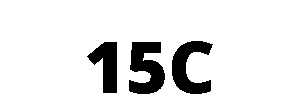

In [71]:
# l.blocks['temperature'].image

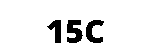

In [72]:
# q.blocks['temperature'].image

In [64]:
# update = {
#     'weather_img': '../Avatar_cloud.png',      # weather_img block will recieve a .png
#     'temperature': '15C',                     # temperature block will receive `15C`
#     'forecast': 'Partly cloudy throughout the day with an east wind at 3m/s. High of 20, 12 overnight.'
# }

In [41]:
# lo = { # basic two row layout
#     'weather_img': {                
#             'image': True,               # image block
#             'width': 1/2,                  # 1/1 of the width - this stretches the entire width of the display
#             'height': 1/4,               # 1/3 of the entire height
#             'abs_coordinates': (0, 0),   # this block is the key block that all other blocks will be defined in terms of
#             'hcenter': True,             # horizontally center text
#             'vcenter': True,             # vertically center text 
#             'relative': False,           # this block is not relative to any other. It has an ABSOLUTE position (0, 0)
#         },
#     'temperature': { 
#                 'image': None,
#                 'max_lines': 1,
#                 'padding': 10,
#                 'width': 1/2,
#                 'height': 1/4,
#                 'abs_coordinates': (None, 0),
#                 'hcenter': True,
#                 'vcenter': True,
#                 'relative': ['weather_img', 'temperature'],
#                 'font': '../fonts/Open_Sans/OpenSans-ExtraBold.ttf',
#                 'font_size': None
#     },
#     'forecast': {
#                 'image': None,
#                 'max_lines': 5,
#                 'padding': 10,
#                 'width': 1,
#                 'height': 1/2,
#                 'abs_coordinates': (0, None),
#                 'hcenter': False,
#                 'vcenter': True,
#                 'relative': ['forecast', 'temperature'],
#                 'font': '../fonts/Open_Sans/OpenSans-Regular.ttf',
#                 'font_size': None
#     }

# }